In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
from finta import TA
import tqdm

import sys
sys.path.insert(1, r'C:\Users\axeli\Desktop\Github\first-child\Python')

import agents, environment

## Part 1. Problem Definition

## Part 2. Data Download and Analysis

In [2]:
from datetime import datetime, timedelta

tickers = ['^DJI', 'GLD', 'TLT']

start_date = '2020-01-01'
end_date = '2024-06-30'
#end_date = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')


data = yf.download(tickers, start = start_date, end = end_date, group_by= 'ticker')
adjc = data.iloc[:, data.columns.get_level_values(1) == 'Adj Close'].droplevel(1, axis = 1)

adjc

[*********************100%%**********************]  3 of 3 completed


Ticker,GLD,^DJI,TLT
Date,,,
2020-01-02,143.949997,28868.800781,123.081192
2020-01-03,145.860001,28634.880859,124.976685
2020-01-06,147.389999,28703.380859,124.267021
2020-01-07,147.970001,28583.679688,123.656120
2020-01-08,146.860001,28745.089844,122.838654
...,...,...,...
2024-06-24,215.630005,39411.210938,94.040878
2024-06-25,214.559998,39112.160156,94.200378
2024-06-26,212.580002,39127.800781,92.854660


In [3]:
data

Ticker             GLD                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2020-01-02  143.860001  144.210007  143.399994  143.949997  143.949997   
2020-01-03  145.750000  146.320007  145.399994  145.860001  145.860001   
2020-01-06  148.440002  148.479996  146.949997  147.389999  147.389999   
2020-01-07  147.570007  148.139999  147.429993  147.970001  147.970001   
2020-01-08  148.490005  148.610001  146.139999  146.860001  146.860001   
...                ...         ...         ...         ...         ...   
2024-06-24  215.550003  215.940002  215.199997  215.630005  215.630005   
2024-06-25  214.960007  215.309998  214.119995  214.559998  214.559998   
2024-06-26  212.389999  213.110001  212.119995  212.580002  212.580002   
2024-06-27  214.710007  215.500000  214.449997  214.990005  214.990005   
2024-06-28  215.639999  215.809998  214.820007  215.009995  215.009995   

Ticker                        ^DJI                                            \
Price         Volume          Open          High           Low         Close   
Date                                                                           
2020-01-02   7733800  28638.970703  28872.800781  28627.769531  28868.800781   
2020-01-03  12272800  28553.330078  28716.310547  28500.359375  28634.880859   
2020-01-06  14403300  28465.500000  28708.019531  28418.630859  28703.380859   
2020-01-07   7978500  28639.179688  28685.500000  28565.279297  28583.679688   
2020-01-08  22248500  28556.140625  28866.179688  28522.509766  28745.089844   
...              ...           ...           ...           ...           ...   
2024-06-24   4626900  39184.488281  39571.230469  39184.488281  39411.210938   
2024-06-25   3847700  39398.789062  39423.261719  38997.230469  39112.160156   
2024-06-26   4690300  39063.148438  39183.738281  38908.988281  39127.800781   
2024-06-27   4977800  39107.101562  39250.691406  39026.750000  39164.058594   
2024-06-28   3955100  39092.390625  39443.601562  38937.148438  39118.859375   

Ticker                                      TLT                          \
Price          Adj Close     Volume        Open        High         Low   
Date                                                                      
2020-01-02  28868.800781  251820000  136.789993  137.529999  136.669998   
2020-01-03  28634.880859  239590000  138.270004  139.160004  137.880005   
2020-01-06  28703.380859  252760000  139.690002  139.710007  138.149994   
2020-01-07  28583.679688  258900000  138.220001  138.470001  137.639999   
2020-01-08  28745.089844  291750000  137.929993  138.309998  136.320007   
...                  ...        ...         ...         ...         ...   
2024-06-24  39411.210938  373940000   94.050003   94.339996   93.739998   
2024-06-25  39112.160156  339010000   94.070000   94.550003   94.040001   
2024-06-26  39127.800781  333100000   93.279999   93.470001   93.110001   
2024-06-27  39164.058594  338010000   93.519997   93.709999   93.419998   
2024-06-28  39118.859375  679630000   93.730003   93.769997   91.779999   

Ticker                                        
Price            Close   Adj Close    Volume  
Date                                          
2020-01-02  137.009995  123.081192  11034100  
2020-01-03  139.119995  124.976685  12366000  
2020-01-06  138.330002  124.267021  11369800  
2020-01-07  137.649994  123.656120   8381200  
2020-01-08  136.740005  122.838654  10621700  
...                ...         ...       ...  
2024-06-24   94.339996   94.040878  56939100  
2024-06-25   94.500000   94.200378  23160000  
2024-06-26   93.150002   92.854660  38489100  
2024-06-27   93.519997   93.223480  23140800  
2024-06-28   91.779999   91.488998  55119600  

[1130 rows x 18 columns]

In [4]:
train1_adjc = adjc.loc[adjc.index < '2023-12-31']
train1_logret = np.log(train1_adjc) - np.log(train1_adjc.shift(1))
test1_adjc = adjc.loc[adjc.index >= '2023-12-31']

train1_logret.corr()

Ticker,GLD,^DJI,TLT
Ticker,,,
GLD,1.000000,0.124865,0.277463
^DJI,0.124865,1.000000,-0.223843
TLT,0.277463,-0.223843,1.000000


### Optimal Weights scraping
Calculate optimal weights using historical data from 01-01-2010 to 31-12-2022

In [5]:
from scipy.optimize import minimize


#test1_logret = np.log(test1_adjc) - np.log(test1_adjc.shift(1))

# Function to calculate expected return, expected volatility and expected sharpe ratio
def get_ret_vol_sr(weights):

    #Takes in weights and returns back an array of mean return, mean volatility and sharpe ratio

    weights = np.array(weights)
    ret = np.sum(train1_logret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(train1_logret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

# We multiply Shrape Ratio for -1 since we will use a minimization function
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# The function will return 0 if the sum of weights is 1
def check_sum(weights):
    return np.sum(weights) - 1

cons = ({'type':'eq','fun': check_sum})
bounds = ((0,1),)*len(tickers)

init_weights = [1/len(tickers)]*len(tickers)

opt_resutls = minimize(neg_sharpe, init_weights, method='SLSQP', bounds = bounds, constraints = cons)

# Get the optimal weights
opt_weights = opt_resutls.x

### First Simulation - Buy and Hold

Final Capital: 110231.38
Gain %: 10.23


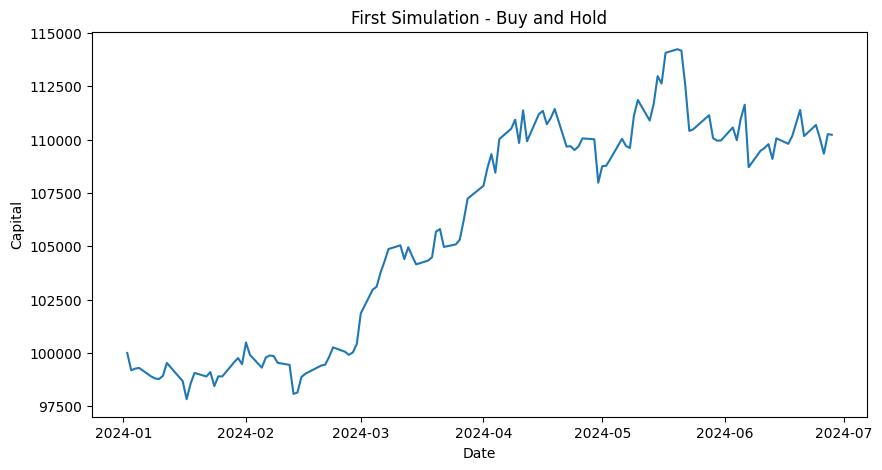

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

PORTFOLIO_VAL = 100000

# Get the cumulative return of the portfolio with the optimal weights
test1_portfolio_daily_ret = (test1_adjc.pct_change() * opt_weights).sum(axis = 1)
buy_and_hold = ((test1_portfolio_daily_ret + 1).cumprod()) * PORTFOLIO_VAL

ax.plot(buy_and_hold)
ax.set_title("First Simulation - Buy and Hold")
ax.set_ylabel("Capital")
ax.set_xlabel("Date")

print(f"Final Capital: {buy_and_hold.iloc[-1]:.2f}\nGain %: {(buy_and_hold.iloc[-1]/PORTFOLIO_VAL-1)*100:.2f}")

## D3QN Model
### Preprocessing

In [7]:
tickers_dict = {}
tickers_ind_dict = {}
tickers_fin_dict = {}

ind_names = ['SMA_30', 'EMA_30', 'RSI_14', 'STOCHK_14', 'STOCHD_3', 'CCI_20']

for t in tickers:

    # Isolate Tickers
    df = data.loc[:, data.columns.get_level_values(0) == t]
    df.columns = df.columns.droplevel(0)
    tickers_dict[t] = df

    # Calculate Indicators
    ind = []
    ind.append(TA.SMA(df, 30))
    ind.append(TA.EMA(df, 30))
    ind.append(TA.RSI(df)/100)
    ind.append(TA.STOCH(df)/100)
    ind.append(TA.STOCHD(df)/100)
    ind.append(TA.CCI(df)/100)

    ind_df = pd.concat(ind, axis = 1)
    ind_df.rename(columns = {k:v for (k, v) in zip(ind_df.columns, ind_names)}, inplace = True)

    tickers_ind_dict[t] = ind_df

    # Calculate other values
    df = df.drop(columns = ['Volume', 'Adj Close'])

    info_dict = {}

    info_dict['C/H(0)'] = df['Close']/df['High'] - 1
    info_dict['C/L(0)'] = df['Close']/df['Low'] - 1
    info_dict['C/O(0)'] = df['Close']/df['Open'] - 1

    info_dict['C/C(-1)'] = df['Close']/df['Close'].shift(1) - 1
    info_dict['C/H(-1)'] = df['Close']/df['High'].shift(1) - 1
    info_dict['C/L(-1)'] = df['Close']/df['Low'].shift(1) - 1
    info_dict['C/O(-1)'] = df['Close']/df['Open'].shift(1) - 1

    info_dict['C/C(-2)'] = df['Close']/df['Close'].shift(2) - 1
    info_dict['C/H(-2)'] = df['Close']/df['High'].shift(2) - 1
    info_dict['C/L(-2)'] = df['Close']/df['Low'].shift(2) - 1
    info_dict['C/O(-2)'] = df['Close']/df['Open'].shift(2) - 1

    info_dict['C/C(-3)'] = df['Close']/df['Close'].shift(3) - 1
    info_dict['C/H(-3)'] = df['Close']/df['High'].shift(3) - 1
    info_dict['C/L(-3)'] = df['Close']/df['Low'].shift(3) - 1
    info_dict['C/O(-3)'] = df['Close']/df['Open'].shift(3) - 1

    info_dict['SMA_30/SMA_30(-1)'] = ind_df['SMA_30']/ind_df['SMA_30'].shift(1) - 1
    info_dict['SMA_30/SMA_30(-2)'] = ind_df['SMA_30']/ind_df['SMA_30'].shift(2) - 1
    info_dict['SMA_30/SMA_30(-3)'] = ind_df['SMA_30']/ind_df['SMA_30'].shift(3) - 1

    info_dict['EMA_30/EMA_30(-1)'] = ind_df['EMA_30']/ind_df['EMA_30'].shift(1) - 1
    info_dict['EMA_30/EMA_30(-2)'] = ind_df['EMA_30']/ind_df['EMA_30'].shift(2) - 1
    info_dict['EMA_30/EMA_30(-3)'] = ind_df['EMA_30']/ind_df['EMA_30'].shift(3) - 1

    tickers_fin_dict[t] = pd.concat([pd.DataFrame(info_dict), ind_df.iloc[:, 2:]], axis = 1)
    tickers_fin_dict[t].rename(columns = {k:f"{t}-{k}" for k in tickers_fin_dict[t].columns}, inplace = True)

In [8]:
X = pd.concat(tickers_fin_dict.values(), axis = 1)
Y = adjc.pct_change(1)

train_cond = (X.index > '2020-02-29') & (X.index <= '2023-12-31')
test_cond = (X.index > '2023-12-31')

X_train = X.loc[train_cond]
Y_train = Y.loc[train_cond]
X_test = X.loc[test_cond]
Y_test = Y.loc[test_cond]


In [19]:
test_env = environment.PortfolioEnv(len(tickers), X_train, Y_train)
state_size = test_env.observation_space.shape[0]
action_size = test_env.action_space.n
test_agent = agents.D3QNAgent(state_size, action_size)
#test_agent.load(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model")

#state = test_env.reset()
#state = np.reshape(state, [1, state_size])

# while True:
#     action = test_agent.act(state, training = False)
#     next_state, reward, done, _ = test_env.step(action, render = False)
#     next_state = np.reshape(next_state, [1, state_size])
#     state = next_state

#     if done:
#         break
#         print(test_env.capital_y)

In [15]:
env = environment.PortfolioEnv(len(tickers), X_train, y_train)  # Initialize the custom trading environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = agents.DDQNAgent(state_size, action_size)

#with tqdm.tqdm(range(10), unit='episode') as tq_ep:
for ep in range(20):
    #tq_ep.set_description(f"Episode: {ep + 1}")
    
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    i = 0

    #print(state)

    with tqdm.tqdm(range(len(X_train)+ 10), unit = 'train') as tq_time:
        for time in tq_time:
            tq_time.set_description(f"Episode: {0}, Time: {i}, Epsilon: {agent.epsilon:.4}. Target Model Updated {i%10} steps ago")
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action, render = False)
            #print(agent.model.predict(state, verbose = 0).sum())
            next_state = np.reshape(next_state, [1, state_size])
            #print(action, env.current_weights)
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            #print(f"\r{env.returns.index[env.current_step-1]}", end = '')

            if done:
                print(f"\nEpisode: {ep+1}/{20}, Epsilon: {agent.epsilon:.2}")
                break
                
            if len(agent.memory) > 30:
                agent.replay(15)
            
            i += 1

            if i % 10 == 0:
                agent.update_target_model()
    
    #agent.save(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model", ep)


c:\Users\axeli\Desktop\Github\first-child\.first-child-venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Episode: 0, Time: 408, Epsilon: 0.1504. Target Model Updated 8 steps ago:  40%|████      | 408/1013 [26:00<38:33,  3.82s/train]  


KeyboardInterrupt: 

In [ ]:
#agent.save(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model", 0)
#agent.load(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model")

AttributeError: 'Sequential' object has no attribute 'load_model'

In [12]:
from collections import deque
deque(pd.read_pickle(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model\memory.pkl").to_records(index = False)), agent.memory

(deque([(array([[-0.00417028,  0.00393515, -0.00178807,  0.01446593, -0.00987644,
                 0.02792639,  0.33333333,  0.33333333,  0.33333333]]), 58, 0.00245255, array([[ 0.00564693, -0.00750152,  0.0014531 , -0.00359589,  0.00384877,
                 0.00685589,  0.7       ,  0.2       ,  0.1       ]]), False),
        (array([[ 0.00564693, -0.00750152,  0.0014531 , -0.00359589,  0.00384877,
                 0.00685589,  0.7       ,  0.2       ,  0.1       ]]), 16, -0.00208897, array([[ 0.00736858, -0.00565165,  0.01305713, -0.01311078,  0.00883239,
                -0.00922722,  0.1       ,  0.5       ,  0.4       ]]), False),
        (array([[ 0.00736858, -0.00565165,  0.01305713, -0.01311078,  0.00883239,
                -0.00922722,  0.1       ,  0.5       ,  0.4       ]]), 5, 0.0030131, array([[-4.59755214e-03,  6.02619250e-03,  2.73715226e-03,
                 3.40481081e-04,  8.39954290e-03, -7.16359769e-03,
                 0.00000000e+00,  5.00000000e-01,  5.00000000e-0

In [ ]:
Action_discretization(3, 10)

(66,
 {0: array([0., 0., 1.]),
  1: array([0. , 0.1, 0.9]),
  2: array([0. , 0.2, 0.8]),
  3: array([0. , 0.3, 0.7]),
  4: array([0. , 0.4, 0.6]),
  5: array([0. , 0.5, 0.5]),
  6: array([0. , 0.6, 0.4]),
  7: array([0. , 0.7, 0.3]),
  8: array([0. , 0.8, 0.2]),
  9: array([0. , 0.9, 0.1]),
  10: array([0., 1., 0.]),
  11: array([0.1, 0. , 0.9]),
  12: array([0.1, 0.1, 0.8]),
  13: array([0.1, 0.2, 0.7]),
  14: array([0.1, 0.3, 0.6]),
  15: array([0.1, 0.4, 0.5]),
  16: array([0.1, 0.5, 0.4]),
  17: array([0.1, 0.6, 0.3]),
  18: array([0.1, 0.7, 0.2]),
  19: array([0.1, 0.8, 0.1]),
  20: array([0.1, 0.9, 0. ]),
  21: array([0.2, 0. , 0.8]),
  22: array([0.2, 0.1, 0.7]),
  23: array([0.2, 0.2, 0.6]),
  24: array([0.2, 0.3, 0.5]),
  25: array([0.2, 0.4, 0.4]),
  26: array([0.2, 0.5, 0.3]),
  27: array([0.2, 0.6, 0.2]),
  28: array([0.2, 0.7, 0.1]),
  29: array([0.2, 0.8, 0. ]),
  30: array([0.3, 0. , 0.7]),
  31: array([0.3, 0.1, 0.6]),
  32: array([0.3, 0.2, 0.5]),
  33: array([0.3, 0.3

## Part 3 - Create the DRL model

In [ ]:
import tensorflow as tf

# Set TensorFlow to use GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)


In [ ]:
def train_ddqnper(episodes):
    env = environment.PortfolioEnv(len(tickers), adjc.iloc[:100], adjc.iloc[:100].pct_change())  # Initialize the custom trading environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    agent = agents.DDQN_PER_Agent(state_size, action_size)

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                agent.update_target_model()
                print(f"Episode {e+1}/{episodes}, score: {time}, e: {agent.epsilon:.2}")
                break
            agent.replay()
        if e % 10 == 0:
            agent.save(f"ddqn_weights_{e}.h5")
            
    return agent

In [ ]:
agent_trained = train_ddqnper(5)

1/99	 Portfolio Value: 101100.51

TypeError: object of type 'PrioritizedReplayBuffer' has no len()

In [ ]:
def train_ddqn(episodes):
    env = environment.PortfolioEnv(len(tickers), adjc.iloc[:100], adjc.iloc[:100].pct_change())  # Initialize the custom trading environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    agent = agents.DDQNAgent(state_size, action_size)

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        for time in range(env.max_steps):  # Set a limit for the number of steps per episode
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action, render = True)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                agent.update_target_model()  # Update target model weights
                print(f"Episode: {e+1}/{episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}")
                break

            agent.replay(20)  # Train the agent with experience replay

    return agent

In [ ]:
trained_agent = train_ddqn(5)
#agents.DDQNAgent(3, 3)

C:\Users\axeli\AppData\Local\Temp\ipykernel_17500\3060608928.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  env = environment.PortfolioEnv(len(tickers), adjc.iloc[:100], adjc.iloc[:100].pct_change())  # Initialize the custom trading environment
c:\Users\axeli\Desktop\Github\first-child\.first-child-venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


DDQN Agent Created
99/99	 Portfolio Value: 66109.45Episode: 1/5, Score: 98, Epsilon: 0.67
99/99	 Portfolio Value: 66109.45Episode: 2/5, Score: 98, Epsilon: 0.41
99/99	 Portfolio Value: 66109.45Episode: 3/5, Score: 98, Epsilon: 0.25
99/99	 Portfolio Value: 66109.45Episode: 4/5, Score: 98, Epsilon: 0.15
99/99	 Portfolio Value: 66109.45Episode: 5/5, Score: 98, Epsilon: 0.094


In [ ]:
import agents

#agents.DQNAgent(3, 3)
import inspect
inspect.getmembers(agents)

#agents.DDQNAgent(3, 3)

[('Adam', keras.src.optimizers.adam.Adam),
 ('DDQNAgent', agents.DDQNAgent),
 ('DQNAgent', agents.DQNAgent),
 ('Dense', keras.src.layers.core.dense.Dense),
 ('Sequential', keras.src.models.sequential.Sequential),
 ('__builtins__',
  {'__name__': 'builtins',
   '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
   '__package__': '',
   '__loader__': _frozen_importlib.BuiltinImporter,
   '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>, origin='built-in'),
   '__build_class__': <function __build_class__>,
   '__import__': <function __import__>,
   'abs': <function abs(x, /)>,
   'all': <function all(iterable, /)>,
   'any': <function any(iterable, /)>,
   'ascii': <function ascii(obj, /)>,
   'bin': <function bin(number, /)>,
   'breakpoint': <function breakpoint>,
   'callable': <function callable(obj, /)>,
   'chr': <function chr(i, /)>,
   'compile': <f

In [ ]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.17.0
[]


In [ ]:
import warnings

def arima_predict(s, p):
    model = arima.auto_arima(s, start_q = 0, start_p = 0, max_p = 3, max_q = 3, n_jobs = -1)
    return model.predict(p, s)#.iloc[p-1]

#tickers_ind_dict['^DJI']['SMA_30'].iloc[29:].rolling(30).apply(arima_predict, kwargs = {'p' : 1})
#tickers_ind_dict['^DJI']['SMA_30'].iloc[29:].rolling(30).apply(arima_predict, kwargs = {'p' : 2})
#tickers_ind_dict['^DJI']['SMA_30'].iloc[29:].rolling(30).apply(arima_predict, kwargs = {'p' : 3})
#arima_predict(tickers_ind_dict['^DJI']['SMA_30'].iloc[29:59], 1)

start = 29

data_pred_dict = {}

for t in tickers:

    #print(f"Starting Preditction for '{t}'...")

    pred_dict = {'index' : [], 'SMA_30(1)' : [], 'EMA_30(1)' : []}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with tqdm.tqdm(range(start, 1130 - 30), unit = 'prediction') as tq_time:
            tq_time.set_description(f"Ticker: {t}")
            for i in tq_time:
                pred_sma = arima_predict(tickers_ind_dict[t]['SMA_30'].iloc[start:i+30], 1)
                pred_ema = arima_predict(tickers_ind_dict[t]['EMA_30'].iloc[start:i+30], 1)
                pred_dict['index'].append(tickers_ind_dict[t]['SMA_30'].index[i+30])
                pred_dict['SMA_30(1)'].append(pred_sma.iloc[0])
                #pred_dict['SMA_30(2)'].append(pred_sma.iloc[1])
                #pred_dict['SMA_30(3)'].append(pred_sma.iloc[2])
                pred_dict['EMA_30(1)'].append(pred_ema.iloc[0])
                #pred_dict['EMA_30(2)'].append(pred_ema.iloc[1])
                #pred_dict['EMA_30(3)'].append(pred_ema.iloc[2])

       
    data_pred_dict[t] = pd.DataFrame(pred_dict)


Ticker: ^DJI:  33%|███▎      | 351/1071 [11:59<24:36,  2.05s/prediction]  


KeyboardInterrupt: 

In [ ]:
from pmdarima import arima

model = arima.auto_arima(tickers_ind_dict['^DJI']['SMA_30'].iloc[29:59])
tickers_ind_dict['^DJI']['SMA_30'].iloc[29:59], model.predict(3, tickers_ind_dict['^DJI']['SMA_30'].iloc[29:50])
model.summary()


c:\Users\axeli\Desktop\Github\first-child\.first-child-venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\axeli\Desktop\Github\first-child\.first-child-venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -140.676
Date:                Sat, 20 Jul 2024   AIC                            287.353
Time:                        20:48:06   BIC                            291.349
Sample:                             0   HQIC                           288.574
                                 - 30                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -13.6103      7.449     -1.827      0.068     -28.210       0.989
ar.L1         -0.3828      0.177     -2.160      0.031      -0.730      -0.036
sigma2      1340.2250    417.484      3.210      0.001     521.971    2158.479
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.92   Prob(JB):                         0.92
Heteroskedasticity (H):               4.53   Skew:                             0.09
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from pmdarima import arima
from statsmodels.tsa.api import VAR

# model = arima.auto_arima(tickers_dict['TLT'][['Close', 'Open']].iloc[:200], n_jobs=-1,
#  start_p = 0, start_q = 0,
#  max_p = 5, max_q = 5)

model = VAR(tickers_dict['GLD'][['Close', 'Open', 'High', 'Low']].iloc[:30])
fitted_model = model.fit(maxlags = 5, ic = 'aic', trend = 'n')

fitted_model.summary()#.exog_names#predict(tickers_dict['TLT'][['Close', 'Open', 'High', 'Low']].iloc[:30])